# Installation

In [1]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.5MB 5.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 4.0MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 3.9MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 3.9MB/s 
     |████████████████████████████████| 215kB 4.3MB/s 
     |████████████████████████████████| 235kB 49.6MB/s 
     |████████████████████████████████| 2.2MB 44.5MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.0-cp37-none-any.whl size=365401 sha256=7fedfd52cd022ef02df3f57b33f3a2de07ab88bded047586891577be61caeb3c
  Stored in directory: /root/.cache/pip/wheels/ce/fb/df/37cd43d1433e65b2d3417a71438404d0e

# Introduction 
Detecting which two nodes in a graph should be connected, i.e. link prediction, is important to many real world applications. Examples include knowledge-graph completion, friend recommendation, and item recommendations for shoppers.  

As we will see in this notebook, training a GNN for link prediction is similar to node prediction:

*  For node prediction, a GNN first computes an embedding for each node, based on each node's features and neighborhood. This embedding is then used to classify the nodes.

*  For link prediction, a GNN can be used to compute an embedding for each node, and then links (i.e. edges) are inferred based on a similarity score between the embeddings.   

# Dataset
We will be working with the PPI dataset. The PPI dataset is composed of tissue-spcific protein-protein interaction (PPI) graphs from the paper "[Predicting Multicellular Function through Multi-layer Tissue Networks](https://arxiv.org/abs/1707.04638)". Each graph represents a PPI network in one human tissue. Each node in the graph has a 50-dimensional feature vector.

We will use the [`train_test_split_edges`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.train_test_split_edges) function in pytorch geometric to create a train / validate / test set for link prediction. This function modifies a `data` object to include the attribute `train_pos_edge_index`, which is an edge list containing  a (user-selected) percentage of edges from the input graph. These edges will be used as positive examples to train a link-prediction model. The remaining edges are contained in the `val_pos_edge_index` and `test_pos_edge_index` edge lists, to be used for validation and testing, respectively. 

In addition to positive examples, it is convenient to have negative examples to facilitate training, validating and testing a binary classifier.  Negative examples for *validation and testing* are contained in  `val_neg_edge_index` and `test_neg_edge_index`, respectively, in the modified `data` object. These are obtaining by randomly sampling pairs of nodes that have no links. 

The `train_test_split_edges` function *does not* provide a training set of negative examples. Negative examples for training, approximately equal in number to positive examples, will be created during training for each epoch using the function [`negative_sampling`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html?highlight=negative%20sampling#torch_geometric.utils.negative_sampling). 

In real graph datasets, "positive" edges at train time include links that have been observed to exist. This information is provided by `train_pos_edge_index`. As this is the most information we can have in a realistic scenario,the remaining edges in the graph are assumed to all be "negative" at train time. These edges also include ones that are truly present but unobserved  yet. Using additional connectivity information other than that provided in `train_pos_edge_index`, would create data leakages. 
Note the number of negative edges ( which is of the order $(N^v \times N^v)$)  is typically much greater than the number of positive edges  in realistic graphs ( which is of the order $N^v$).

In [2]:
import torch
from torch_geometric.datasets import PPI
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import DataLoader

# Set the device for training
device='cuda' if torch.cuda.is_available() else 'cpu'

# Load dataset 
PPI.url = "https://data.dgl.ai/dataset/ppi.zip" #  Workaround for wrong URL in pytorch geometric

dataset_ppi = PPI(root="./tmp/ppi") 

# For simplicity, pick the largest graph out of the dataset
data = max(dataset_ppi, key= lambda x:x.num_nodes) 

# Remove properties related to node-labeling (not needed here)
data.train_mask = data.val_mask = data.test_mask = data.y = None

# Create train/val/test split
data = train_test_split_edges(data, val_ratio=0.25, test_ratio=0.25,)

Extracting tmp/ppi/ppi.zip
Processing...
Done!


In [3]:
# Observe the dataset keys
data.keys

['x',
 'val_pos_edge_index',
 'test_pos_edge_index',
 'train_pos_edge_index',
 'train_neg_adj_mask',
 'val_neg_edge_index',
 'test_neg_edge_index']

# Link Prediction

Many link prediction algorithms can be described in an encoder-decoder framework (see [Representation Learning on Graphs: Methods and Applications](https://arxiv.org/pdf/1709.05584.pdf))


## Encoder
An encoder is used to map nodes to a $d-$dimensional vector:
$$ \mathrm{ENC}: V \rightarrow \mathbb{R}^d $$

A GNN-based encoder can naturally make use of node features if they are available. If these aren't available, one can use a vector of ones of a specified demension or a one hot encoding of the vector label (i.e. the identity matrix). However this one hot-encoding doesn't generelize to unseen nodes. 

We will define a simple encoder using the *SGConv* operator 

In [4]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import SGConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

class Encoder(torch.nn.Module):
    def __init__(self,data):
        super().__init__()
        self.conv1 = SGConv(data.num_features, 20)
        self.conv2 = SGConv(20, 4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)

        return x

## Decoder

A decoder for link prediction typically takes a pair of embeddings and outputs a real-valued similarity measure, which can then be used to predict an existance of an edge or, during training, used to compute a loss function

$$ \mathrm{DEC}: \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R} $$

For our decoder, we will use the dot product as the decoder function.




In [5]:
def decode(z,edge_index):
      # Get features of the source nodes of the edge list (|E| X |F|)
      z_j = z[edge_index[0],:]

      # Get features of the target nodes of the edge list (|E| X |F|)
      z_i = z[edge_index[1],:]

      # get dot product by element wise multiplication followed by the sum
      # (|E| X |E| -> |E| X |F| -> |E|)
      dot_product =torch.sum(z_i*z_j, axis=1)
      return dot_product

## Loss function

In order to train the encoder, we will use cross-entropy loss, computed on the union of the positive and negative edges:

$$  \sum_{v_i, v_j \in  \cup(E,E_n)}  y_{ij} log(\hat{y}_{ij}) + (1-y_{ij}) log(1- \hat{y}_{ij}) $$

where

$$ \hat{y}_{ij} = \sigma(z_i^Tz_j) $$  

and 

$$z_i = \mathrm{ENC}(v_i)$$

Here $\sigma$ is the sigmoid function

In [6]:
def get_edge_loss(z, data, neg_edge_index):
    pos_edge_index = data.train_pos_edge_index
    
    # Inner product of node representations for positive edges
    logits_pos = decode(z,pos_edge_index)

    # Inner product of node representations for negative edges
    logits_neg = decode(z,neg_edge_index)

    loss_pos = F.binary_cross_entropy_with_logits(logits_pos, torch.ones(pos_edge_index.shape[1], device=logits_neg.device))
    loss_neg = F.binary_cross_entropy_with_logits(logits_neg, torch.zeros(neg_edge_index.shape[1], device=logits_neg.device))

    loss = (loss_pos + loss_neg)/2.
    

    return loss

## Training loop

Everything is now setup to train and evaluate the model. 
We will be using the [area under curve metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) to evaluate the link predictions

For validation and testing, we will need "negative" edge lists as well, which represent edges *not* in the original graph. These will be fixed at the start. For training, we will create a different "negative" edge list for every training epoch. Note that the negative edges in the training set may contain "positive" edges that appear in the validation or test sets. This is fine as it simulates realistic use-cases, since we should assume we do not know the test-case before-hand. 

In [7]:
def train(data,model, optimizer):
  model.train()
  optimizer.zero_grad()

  z = model(data.x, data.train_pos_edge_index)

  # Create a negative sample
  neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index,
                                    num_nodes=data.x.size(0)).to(device)
    
  loss = get_edge_loss(z, data, neg_edge_index)
  loss.backward()
  optimizer.step()
  return loss.item()

def test(data, model, seg ="val"):
  with torch.no_grad():
    model.eval()
    z = model(data.x, data.train_pos_edge_index)

    if seg=="val":
      pos_edge_index = data.val_pos_edge_index
      neg_edge_index = data.val_neg_edge_index
    if seg =="test":
      pos_edge_index = data.test_pos_edge_index
      neg_edge_index = data.test_neg_edge_index

    # Inner product of node representations for positive edges
    logits_pos = decode(z,pos_edge_index)

      # Inner product of node representations for negative edges
    logits_neg = decode(z,neg_edge_index)

    edge_pos_pred = torch.sigmoid(logits_pos)
    edge_neg_pred = torch.sigmoid(logits_neg)
    edge_pred = torch.cat([edge_pos_pred, edge_neg_pred])
    edge_true = torch.cat([torch.ones_like(edge_pos_pred), torch.zeros_like(edge_neg_pred)])
    edge_true = edge_true.cpu().numpy()
    edge_pred = edge_pred.cpu().numpy()
    score = roc_auc_score(edge_true, edge_pred)
    return score

In [8]:
model, data = Encoder(data).to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01,weight_decay=0.001)
print("Training Loss \t Validation AUC")

for epoch in range(1, 201):
  loss = train(data,model,optimizer)

  if epoch % 10==0:  
    score_val = test(data,model, seg="val")
    print(loss, score_val)

Training Loss 	 Validation AUC
0.642419695854187 0.8041238968133049
0.6172358989715576 0.7856331756761856
0.6048412919044495 0.8004562346076377
0.5957413911819458 0.8105762860484993
0.5902160406112671 0.8107380496232511
0.5867340564727783 0.8138726541249015
0.5861576795578003 0.8141760647237606
0.5869420766830444 0.8118908369257831
0.5841619968414307 0.8139880743786265
0.5842652320861816 0.8111678288888673
0.5829986929893494 0.8120131761047995
0.5826578736305237 0.8116008738647571
0.5848013162612915 0.8117578357502846
0.5849543809890747 0.8113962432796569
0.5841080546379089 0.8115172149600464
0.5846112370491028 0.8121402074608298
0.5854957103729248 0.8127907521105417
0.5850664973258972 0.8107659808529076
0.5853132009506226 0.8122242931823606
0.5855624079704285 0.811842075912112


# Optional Exercise 1



Try to reproduce the results obtained by the GAE model that are presented in the paper  [Variational Graph Auto-Encoders](https://arxiv.org/pdf/1611.07308.pdf) for the Cora, Citeseer and Pubmed citation networks. These citation networks can be accessed via the [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=Planetoid#torch_geometric.datasets.Planetoid) class in PyG. The results are reproduced below.

<center>
<img src="https://ai.science/api/authorized-images/G%2Bvy4TibWK9Jc3VPnKTm71ttzh%2BU2Ub%2BcPoUcYgq747SdekgH3hIH%2FUf5alSv6tKJk8lsq1Hj1DcaSNsRmbLtKa1cXLWBCAFR7of47qaKMPIXLn%2Bw9toOfso%2Fmyn%2BDI6mKiXclhefuVGP6LTAu2klOzCwcTMfuQKRRVCmIO%2BhHAjhwtZItG%2BkMR7i3nfez3npbVXk%2BgbYxrvDbhQRdj%2F8TzoLcr2DLoRtTsxvY6GmrqFLkbOu2zjcTt98ZX42T7C98vd1Jb9hGeXhAgO1RZlYdcOyJqjpNOBE%2BzUz%2B1MwNtOMZn8J4KXiL1YRkvhgu4H%2Bfo8wkrfAdWCEWTwPynokYPTJmrsaNnDymZCAz2kuBaHGq8t%2B8IOeN12T9zZ2KrFk3d5%2FX7N%2BuLi2K08328Q5nLU1ggXKsu4njxvXUUc8sjP9NRL61exrZaLc4ctkuAy5cdanl9SxzWp08cvJpqEezLhvpMR0XVzBZpMfPEb9YUgrBgrVkmAeZdatzWElLZ9czaHLwkXFucS62gnrE8HXjnEv5N09fDEU94EL79OUPCSxxz%2FxKFgIRpQegAaBwBOcyWDzEuEWtJmv0otblkKAB%2F9th6pxOU02kNP3j0YOeJH87dNPFxMsM8ZKAKJ2PCjMtQVg3Ew7TK8jn19TIDYbXemXtmxl0PVF4fK5ycs0Vg%3D" width="60%" > </center>


Things to try:
* Change the convolutional operator in the encoder above to include nonlinearities
* Try to replace the node features with a vector of ones of a specified size. How do these results compare to using the node features?
* Try to replace the node features with a one hot encoded node indices (i.e. identity matrix)




## Reference Solution
Here, we will exame the influence of embedding sizes for two different types convolution layers in all three datasets. You can try to futher fine-tune the model to reproduce the results of the paper, particularly for the PubMed dataset

### Get Datasets

In [9]:
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [10]:
def prepare_dataset(dataset, val_ratio, test_ratio):
    # Take the largest subgraph (if the dataset is not connected)
    data = max(dataset, key= lambda x:x.num_nodes) 
    # Create train/val/test split
    data = train_test_split_edges(data, val_ratio=val_ratio, test_ratio=test_ratio)
    return data

In [11]:
data_cora = prepare_dataset(Planetoid('/content/data/cora', 'Cora'), 0.05, 0.10)
data_citeseer = prepare_dataset(Planetoid('/content/data/citeseer', 'CiteSeer'), 0.05, 0.10)
data_pubmed = prepare_dataset(Planetoid('/content/data/pubmed', 'PubMed'), 0.05, 0.10)

Processing...
Done!
Processing...
Done!
Processing...
Done!


We will define a new encoder with one layer of convolution operation and reuse the training loop above. We will make the convolution layer type and embedding size configurable

In [12]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import SGConv, GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

class Encoder(torch.nn.Module):
    def __init__(self, data, conv_layer, embedding_size):
        super().__init__()
        self.conv = conv_layer(data.num_features, embedding_size)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return x

We will plot the validation accuracy of different embedding sizes and convolutional operators ([SGConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=GCNConv#torch_geometric.nn.conv.SGConv) and [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=GCNConv#torch_geometric.nn.conv.GCNConv))

In [13]:
def test_model(data, conv_layer, embedding_size, epoches, seg, device):
    model, data = Encoder(data, conv_layer, embedding_size).to(device), data.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01,weight_decay=0.001)
    for epoch in range(0, epoches):
        train(data,model,optimizer)
    return test(data, model, seg=seg)

In [14]:
def plot_test_performances(datasets, conv_layers, dataset_names, conv_layer_names,
                          embedding_sizes, epoches):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    f, axes = plt.subplots(1, len(datasets), figsize=(9,3))
    for i, dataset in enumerate(tqdm(datasets)):
        axes[i].set_title(dataset_names[i])
        for j, conv_layer in enumerate(tqdm(conv_layers, leave=False)):
            aucs = [test_model(dataset, conv_layer, size, epoches, 'test', device) \
                    for size in tqdm(embedding_sizes, leave=False)]
            axes[i].plot(embedding_sizes, aucs, label=conv_layer_names[j])
        axes[i].legend()
    plt.show()

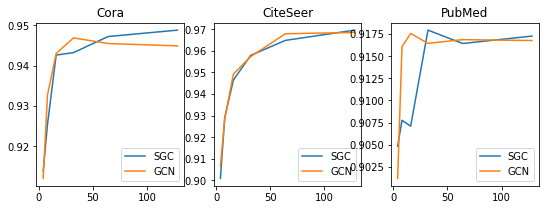

In [15]:
embedding_sizes = [4, 8, 16, 32, 64, 128]
datasets = [data_cora, data_citeseer, data_pubmed]
dataset_names = ['Cora', 'CiteSeer', 'PubMed']
conv_layers = [SGConv, GCNConv]
conv_layer_names = ['SGC', 'GCN']

plot_test_performances(datasets, conv_layers, dataset_names, conv_layer_names, 
                      embedding_sizes, 100)

Now, lets replace the feature matrix with matrix of ones

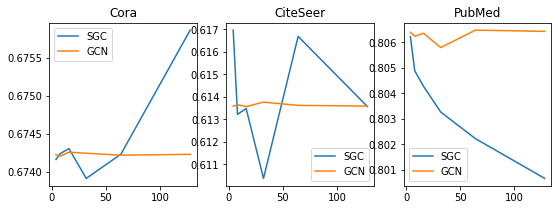

In [16]:
data_cora = prepare_dataset(Planetoid('/content/data/cora', 'Cora'), 0.5, 0.10)
data_citeseer = prepare_dataset(Planetoid('/content/data/citeseer', 'CiteSeer'), 0.5, 0.10)
data_pubmed = prepare_dataset(Planetoid('/content/data/pubmed', 'PubMed'), 0.5, 0.10)

embedding_sizes = [4, 8, 16, 32, 64, 128]
datasets = [data_cora, data_citeseer, data_pubmed]
dataset_names = ['Cora', 'CiteSeer', 'PubMed']
conv_layers = [SGConv, GCNConv]
conv_layer_names = ['SGC', 'GCN']

# replace the feature vector of each dataset to vector of ones
for dataset in datasets:
    dataset.x = torch.ones_like(dataset.x)

plot_test_performances(datasets, conv_layers, dataset_names, conv_layer_names, 
                      embedding_sizes, 100)

Now, lets' try one-hot encoding

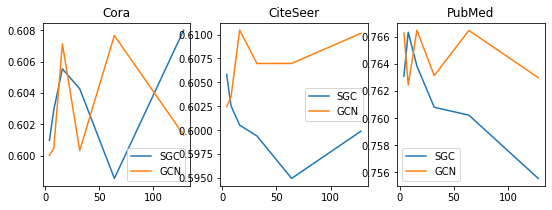

In [17]:
data_cora = prepare_dataset(Planetoid('/content/data/cora', 'Cora'), 0.05, 0.10)
data_citeseer = prepare_dataset(Planetoid('/content/data/citeseer', 'CiteSeer'), 0.05, 0.10)
data_pubmed = prepare_dataset(Planetoid('/content/data/pubmed', 'PubMed'), 0.5, 00.10)

embedding_sizes = [4, 8, 16, 32, 64, 128]
datasets = [data_cora, data_citeseer, data_pubmed]
dataset_names = ['Cora', 'CiteSeer', 'PubMed']
conv_layers = [SGConv, GCNConv]
conv_layer_names = ['SGC', 'GCN']

# replace the feature vector of each dataset to indentity matrix
for dataset in datasets:
    dataset.x = torch.eye(dataset.num_nodes)

plot_test_performances(datasets, conv_layers, dataset_names, conv_layer_names, 
                      embedding_sizes, 100)

# Optional Exercise 2 
[Node2Vec](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf) is a popular node embedding algorithm. However it does not use features to compute the node embeddings. Node2Vec is included in PyG (see the example [here](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py) for usage).  Train a Node2Vec encoder and compare it the results in the previous exercise. 

Note: Make sure to only pass in data.train_pos_edge_index while training the Node2Vec encoder.

## Reference Solution
Here, we can use the Node2Vec embedding followed by a dot product to directly predict the links. In real world scenario, however, we may wish to feed the embedding into another classifier (e.g. Logistic Regression, SVM, etc.)

In [18]:
from torch_geometric.nn import Node2Vec

In [19]:
def train(data,model, loader, optimizer):
  model.train()
  optimizer.zero_grad()

#   Create a negative sample
  for pos_rw, neg_rw in loader:
    optimizer.zero_grad()
    loss = model.loss(pos_rw.to(device), neg_rw.to(device))
    loss.backward()
    optimizer.step()
    
  return loss.item()

def test(data, model, seg ="val"):
  with torch.no_grad():
    model.eval()
    z = model()

    if seg=="val":
      pos_edge_index = data.val_pos_edge_index
      neg_edge_index = data.val_neg_edge_index
    if seg =="test":
      pos_edge_index = data.test_pos_edge_index
      neg_edge_index = data.test_neg_edge_index

    # Inner product of node representations for positive edges
    logits_pos = decode(z,pos_edge_index)

      # Inner product of node representations for negative edges
    logits_neg = decode(z,neg_edge_index)

    edge_pos_pred = torch.sigmoid(logits_pos)
    edge_neg_pred = torch.sigmoid(logits_neg)
    edge_pred = torch.cat([edge_pos_pred, edge_neg_pred])
    edge_true = torch.cat([torch.ones_like(edge_pos_pred), torch.zeros_like(edge_neg_pred)])
    edge_true = edge_true.cpu().numpy()
    edge_pred = edge_pred.cpu().numpy()
    score = roc_auc_score(edge_true, edge_pred)
    return score

def test_model(data, embedding_size, epoches, seg, device):
    # instead of using encoder, we use Node2Vec embedding
    model = Node2Vec(data.train_pos_edge_index, embedding_dim=embedding_size, walk_length=20,
                    context_size=10, walks_per_node=10, num_nodes=data.num_nodes,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)
    data =  data.to(device)
    optimizer = torch.optim.SparseAdam (params=model.parameters(), lr=0.01)
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

    for epoch in tqdm(range(0, epoches)):
        train(data,model,loader,optimizer)
    return test(data, model, seg=seg)

In [20]:
# Load dataset
data_cora = prepare_dataset(Planetoid('/content/data/cora', 'Cora'), 0.5, 0.10)
data_citeseer = prepare_dataset(Planetoid('/content/data/citeseer', 'CiteSeer'), 0.5, 0.10)
data_pubmed = prepare_dataset(Planetoid('/content/data/pubmed', 'PubMed'), 0.5, 0.10)

In [21]:
embedding_size = 128
datasets = [data_cora, data_citeseer, data_pubmed]
dataset_names = ['Cora', 'CiteSeer', 'PubMed']

for name, dataset in zip(dataset_names, datasets):
    val_auc = test_model(dataset, embedding_size, 100, 'test', device)
    print(f'{name}: {val_auc}')


Cora: 0.6456473756791692



CiteSeer: 0.60923559956527



PubMed: 0.7349802144560726


# References

 [Variational Graph Auto-Encoders](https://arxiv.org/pdf/1611.07308.pdf)

 [Node2Vec](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf) 

